# **Tomato Disease Classification**

## **Introduction**

Early detection of **tomato diseases** is crucial for crop protection and yield optimization. This project leverages **deep learning** techniques to automatically classify various tomato diseases from leaf images.

Diseases considered in this project:
- *Tomato_Late_blight* - Essential to include because:
    - One of the most destructive tomato diseases globally
    - Can cause 100% crop loss in severe cases
    - Historically significant (caused the Irish Potato Famine)
    - Still a major concern for farmers worldwide
- *Tomato__Tomato_YellowLeaf__Curl_Virus (TYLCV)*
    - Among the most devastating tomato diseases worldwide
    - Can cause up to 100% yield loss
    - Spreading globally due to climate change
    - Very difficult to control once established

- *Tomato_Early_blight*
    - One of the most common tomato diseases
    - Occurs in most tomato-growing regions
    - Can cause significant yield reductions (up to 79%)
    - Often appears early in the growing season

- *Tomato_healthy* (Important to include as a control class)
    - Essential for model comparison
    - Helps reduce false positives
    - Important for model validation
    - Makes the model more practical.

---
## **Importing Libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

---
## **Data Collection**

In [ ]:
data_path = '/content/drive/MyDrive/ML Projects/Tomato Disease Classification/data/PlantVillage'
IMAGE_SIZE = 256
CHANNELS = 3 #-- for RGB
NUM_CLASSES = 4
BATCH_SIZE = 32
EPOCHS = 20

The following code generates a `tf.data.Dataset` from image files in a directory:

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 7738 files belonging to 4 classes.


---
## **Inspection**

In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy']

In [ ]:
class_names_as_titles = ['Early blight',
                         'Late blight',
                         'Yellow Leaf Curl Virus',
                         'Healthy']

In [ ]:
print(f'Dataset length: {len(dataset)} batches of {BATCH_SIZE} images each one.')

Dataset length: 242 batches of 32 images each one.


In [ ]:
# Get one batch
image_batch, label_batch = next(iter(dataset))
print(image_batch.shape)
print(label_batch)

(32, 256, 256, 3)
tf.Tensor([1 2 2 3 2 2 0 2 2 3 2 3 3 2 2 0 2 0 2 2 2 1 3 0 3 2 2 1 1 2 3 1], shape=(32,), dtype=int32)


A batch is a set of 32 colored images of 256x256 pixels each.

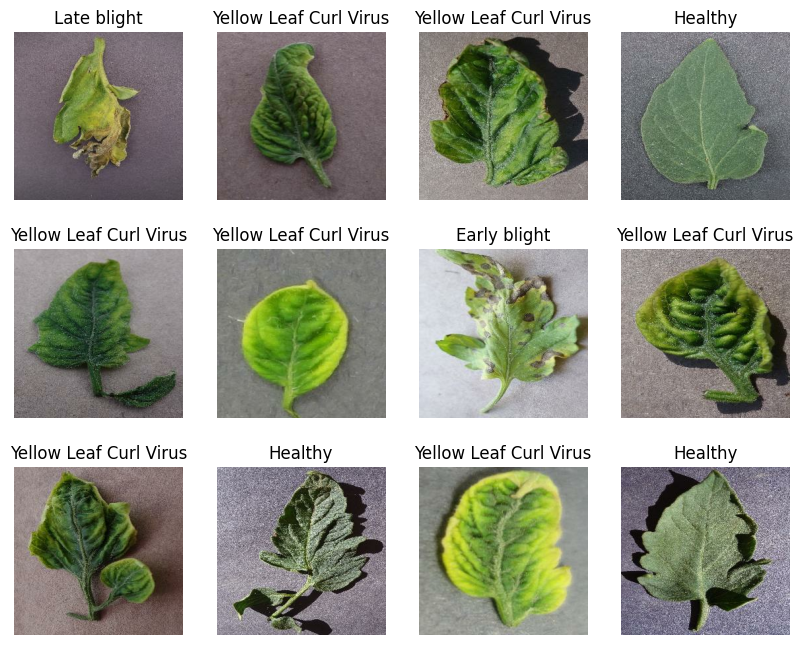

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names_as_titles[label_batch[i]])
    ax.axis('off')

---
## **Data Splitting**

In [ ]:
def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1,
                  shuffle_size=10000):
    '''
    Split a tensorflow dataset into train, validation and test sets.

    Args:
        dataset: The original dataset
        train_slit: Proportion of data for training (default 0.7)
        val_split: Proportion of data for validation (default 0.15)
        test_split: Proportion of data for testing (default 0.15)
        shuffle_size: Buffer size for shuffling

    Returns:
        train_dataset, val_dataset, test_dataset
    '''
    # Ensure splits sum 1
    assert train_split + val_split + test_split == 1.0

    # Get the total size of the original dataset
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    # Shuffle the dataset
    dataset = dataset.shuffle(shuffle_size, seed=42)

    # Calculate sizes for each split
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    # Split into train, validation, and test
    train_ds = dataset.take(train_size)
    remaining = dataset.skip(train_size)
    val_ds = remaining.take(val_size)
    test_ds = remaining.skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = split_dataset(dataset)
len(train_ds), len(val_ds),len (test_ds)

(193, 24, 25)

## **Building the Model**

A simple architecture will work for this task. Plant disease features are relatively straightforward to detect (spots, discoloration, patterns).Besides, with only 4 classes, we don't need extremly deep feature hierarchies.

After some trial and error, it seems like six identical `Conv2D`(64) blocks provide a good depth without overcomplicating. Regular `MaxPooling` progressively reduces spatial dimensions while maintaining important features, and single `Dense` (64) layer is sufficient for final classification given the problem's complexity.

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
def create_tomato_disease_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                num_classes=NUM_CLASSES):
    '''
    Create a CNN model for tomato disease classification

    Args:
        input_shape: Input image dimensions (height, width, channels)
        num_classes: Number of disease classes to predict

    Returns:
        model: Compiled keras model
    '''
    # Data Agumentation Layer
    data_augmentation = models.Sequential([
        # layers.RandomRotation(0.2), #-- problem when loading the saved model :(
        layers.RandomFlip('horizontal'),
        layers.RandomFlip('vertical'),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
    ], name='data_augmentation')

    # Build the model
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    return model

In [ ]:
model = create_tomato_disease_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

---
## **Model Training**

In [ ]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=val_ds)

Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 82s 197ms/step - accuracy: 0.4990 - loss: 2.5166 - val_accuracy: 0.8268 - val_loss: 0.4276
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 62s 188ms/step - accuracy: 0.8210 - loss: 0.4716 - val_accuracy: 0.8685 - val_loss: 0.3561
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 58s 187ms/step - accuracy: 0.8534 - loss: 0.3850 - val_accuracy: 0.8776 - val_loss: 0.3168
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - accuracy: 0.8707 - loss: 0.3504 - val_accuracy: 0.8763 - val_loss: 0.2853
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 58s 188ms/step - accuracy: 0.8816 - loss: 0.3013 - val_accuracy: 0.8763 - val_loss: 0.3848
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.8890 - loss: 0.2826 - val_accuracy: 0.9357 - val_loss: 0.1624
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 82s 190ms/step - accuracy: 0.8984 - loss: 0.2590 - val_accuracy: 0.8698 - val_loss: 0.3426
Epoch 8/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.9037 - loss: 0

In [ ]:
model_version = 'v3'
save_path = f'/content/drive/MyDrive/ML Projects/Tomato Disease Classification/models/{model_version}/'

# Create directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

### **Performance Visualization**

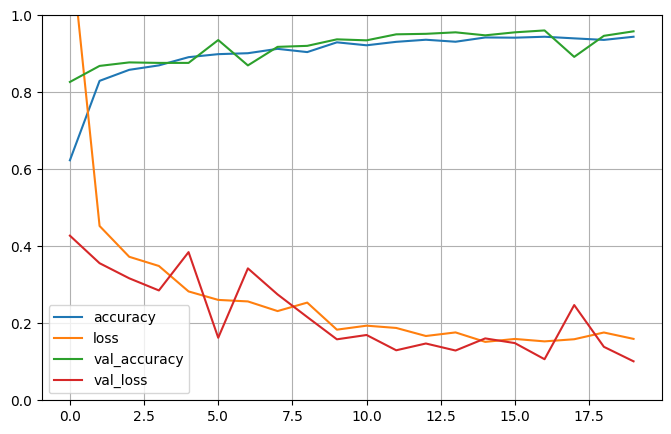

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig(save_path + 'hist.png')
plt.show()

The training results show excellent performance with good leaerning progression over 20 epochs. The model rapidly improves and maintains stable learning without significant overfitting.

---
## **Model Evaluation**

In [ ]:
scores = model.evaluate(test_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9434 - loss: 0.1658


In [ ]:
def plot_predictions(model, test_ds, num_images=9):
    # Get a batch of test images
    images, labels = next(iter(test_ds))

    # Make predictions
    predictions = model.predict(images)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        predicted_label = np.argmax(predictions[i])
        actual_label = labels[i]
        if isinstance(actual_label, np.ndarray):
            actual_label = np.argmax(actual_label)
        confidence = predictions[i][predicted_label] * 100

        # Plot the image
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        # Create color-coded title based on correctness
        color = 'green' if predicted_label == actual_label else 'red'
        predicted_label = class_names_as_titles[predicted_label]
        actual_label = class_names_as_titles[actual_label]
        title = f'Pred: {predicted_label}\nTrue: {actual_label}\nConf: {confidence:.1f}'

        plt.title(title, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(save_path + 'preds.png')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


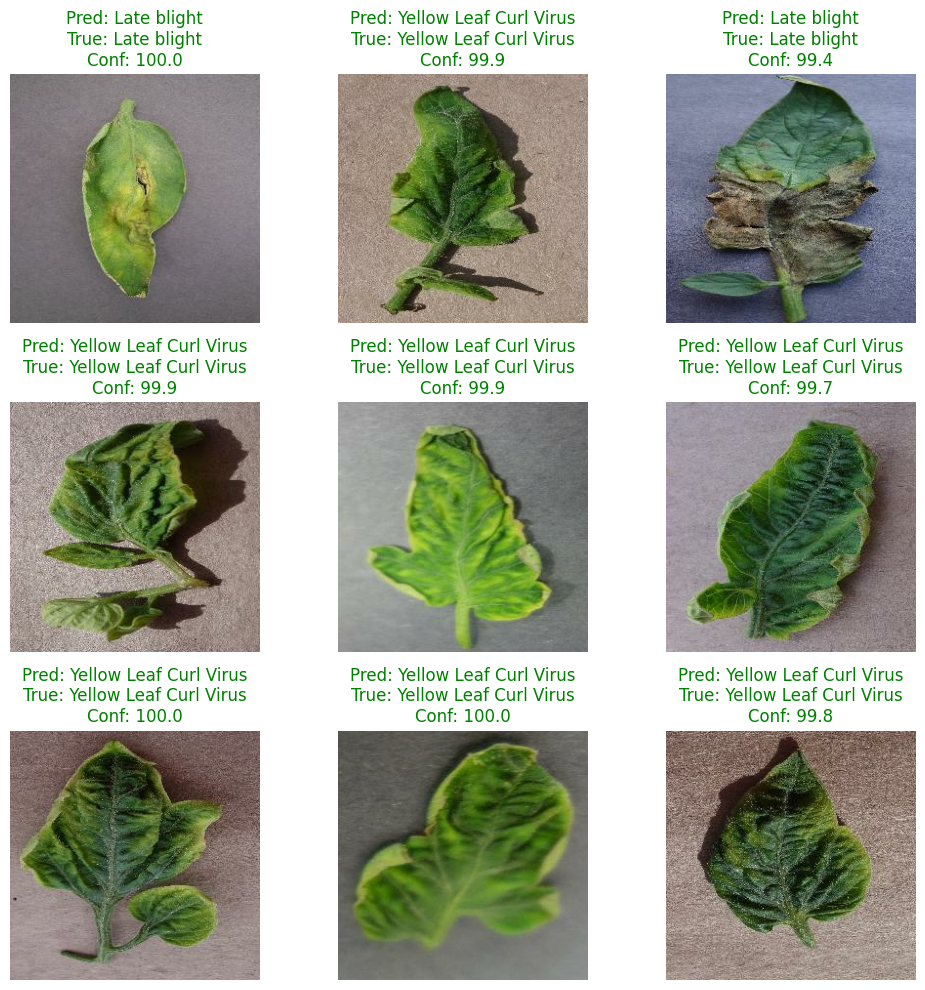

In [ ]:
plot_predictions(model, test_ds)

In [ ]:
model.save(save_path + 'model.keras')